In [1]:
import os
from pathlib import Path

data_dir = os.path.join(Path.home(), 'workspace/machine-learning/resource/jena-climate')
jena_path = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# Read sequences from jena_climate csv file.
fname = open(jena_path)
data = fname.read()
fname.close()

In [2]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print('The number of lines =', len(lines))

The number of lines = 420551


In [3]:
import numpy as np

n_sequences = len(lines)
n_labels = len(header) - 1

sequences = np.zeros((n_sequences, n_labels))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    sequences[i] = values

In [4]:
print('The shape of sequences =', sequences.shape)

The shape of sequences = (420551, 14)


In [5]:
# Standardize training samples

n_train_data = 200000
train_data = sequences[:n_train_data]

mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)

sequences -= mean
sequences /= std

In [6]:
'''
Return a generated pair of samples and targets.
looback is interval of each samples.
steps is sampling rate.
delay is a time point of target.
'''
def sample_generator(data, lookback, delay, min_index, max_index,
                     shuffle=False, batch_size=128, step=6):
    n_samples = len(data)
    n_labels = data.shape[-1]
    if max_index is None:
        max_index = n_samples - delay - 1
    gen_idx = min_index + lookback

    while 1:
        if shuffle:
            # Choose entry indices randomly.
            entries = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            # Choose entry indices sequentialy.
            if gen_idx + batch_size >= max_index:
                gen_idx = min_index + lookback
            last = min(gen_idx + batch_size, max_index)
            entries = np.arange(gen_idx, last)
            gen_idx += len(entries)

        n_entries = len(entries)
        samples = np.zeros((n_entries, lookback // step, n_labels))
        targets = np.zeros((n_entries))
        # Choose samples from entry indice.
        for i, entry in enumerate(entries):
            indices = range(entry - lookback, entry, step)
            temperature = data[entry + delay][1]
            samples[i] = data[indices]
            targets[i] = temperature
        yield samples, targets

In [7]:
'''
looback, 1440 samples, Interval is 10 days each each samples.
step, 3 unit time, Choose 1 sample every a half hour.
delay, 144 unit time, Target value is a temperature data after 24 hours.
'''
lookback = 1440
step = 3
delay = 144
batch_size = 128

n_samples = len(sequences)
n_train_data = 200000
n_val_data = 100000

train_gen = sample_generator(sequences,
                             lookback=lookback,
                             delay=delay,
                             min_index=0,
                             max_index=n_train_data,
                             shuffle=True,
                             step=step,
                             batch_size=batch_size)
val_gen = sample_generator(sequences,
                           lookback=lookback,
                           delay=delay,
                           min_index=n_train_data+1,
                           max_index=n_train_data+n_val_data,
                           step=step,
                           batch_size=batch_size)
test_gen = sample_generator(sequences,
                            lookback=lookback,
                            delay=delay,
                            min_index=n_train_data+n_val_data+1,
                            max_index=None,
                            step=step,
                            batch_size=batch_size)

In [8]:
val_steps = (n_val_data - lookback) // batch_size
test_steps = (n_samples - n_train_data - n_val_data - lookback) // batch_size

print('The number of validation batches =', val_steps)
print('The number of test batches =', test_steps)

The number of validation batches = 770
The number of test batches = 930


In [9]:
# Case I : Using CNN layers to preprocess before push to RNN layer.
# CNN layers make short sequences that represent more abstract features.

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv1D(filters=32,
                        kernel_size=5,
                        input_shape=(None, sequences.shape[-1]),
                        activation='relu'))
model.add(layers.MaxPooling1D(pool_size=3))
model.add(layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation='relu'))
model.add(layers.GRU(units=32,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 97s 193ms/step - loss: 0.3348 - val_loss: 0.2844
Epoch 2/20
500/500 [==============================] - 92s 184ms/step - loss: 0.3031 - val_loss: 0.2865
Epoch 3/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2923 - val_loss: 0.2723
Epoch 4/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2834 - val_loss: 0.2676
Epoch 5/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2777 - val_loss: 0.2700
Epoch 6/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2720 - val_loss: 0.2727
Epoch 7/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2665 - val_loss: 0.2873
Epoch 8/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2627 - val_loss: 0.2711
Epoch 9/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2579 - val_loss: 0.2841
Epoch 10/20
500/500 [==============================] - 92s 185ms/step - l

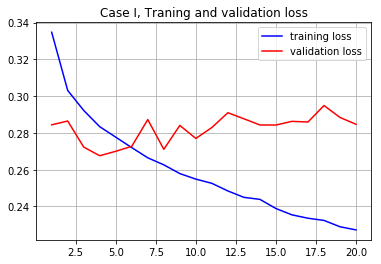

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(len(loss)) + 1

plt.figure('Case I, Traning and validation loss')
plt.title('Case I, Traning and validation loss')
plt.plot(epochs, loss, color='b', label='training loss')
plt.plot(epochs, val_loss, color='r', label='validation loss')
plt.legend()
plt.grid()
plt.show()

# Validation loss about 0.27. It is not less than naive model(0.289)!